Adınız: Tunahan

Soyadınız: Karabulut

Okul Numaranız: 2212721024

GitHub Repo Bağlantısı:https://github.com/Tonau0o0/ACO_Yol_Optimizasyonu

Amacım, algoritmanın optimizasyon yeteneğini test eetmek olduğu için yol karmaşıklığını azaltmaya yönelik koordinat kullandım.

In [21]:
#Kütüphaneler
import numpy as np
import random
import matplotlib.pyplot as plt


In [22]:
# ==========================================
# Antalya / Muratpaşa
# 20 Magaza Koordinatlari
# ==========================================

lokasyonlar = {
    "Depot": (36.8841, 30.7056),

    "Magaza_1":  (36.8855, 30.7101),
    "Magaza_2":  (36.8823, 30.7022),
    "Magaza_3":  (36.8870, 30.6995),
    "Magaza_4":  (36.8891, 30.7078),
    "Magaza_5":  (36.8817, 30.7093),

    "Magaza_6":  (36.8789, 30.7034),
    "Magaza_7":  (36.8862, 30.7130),
    "Magaza_8":  (36.8905, 30.7002),
    "Magaza_9":  (36.8831, 30.7156),
    "Magaza_10": (36.8795, 30.7088),

    "Magaza_11": (36.8884, 30.7041),
    "Magaza_12": (36.8812, 30.6979),
    "Magaza_13": (36.8920, 30.7099),
    "Magaza_14": (36.8768, 30.7020),
    "Magaza_15": (36.8899, 30.7137),

    "Magaza_16": (36.8829, 30.7064),
    "Magaza_17": (36.8858, 30.6983),
    "Magaza_18": (36.8781, 30.7112),
    "Magaza_19": (36.8911, 30.7050),
    "Magaza_20": (36.8847, 30.7008),
}


In [23]:
import numpy as np
from math import sqrt

def oklid_mesafesi(nokta1, nokta2):
    #Iki nokta arasindaki Oklid mesafesini hesaplar
    return sqrt((nokta1[0] - nokta2[0])**2 + (nokta1[1] - nokta2[1])**2)


def mesafe_matrisi_olustur(lokasyonlar):
    #Tüm lokasyonlar için mesafe matrisi üretir
    koordinatlar = list(lokasyonlar.values())
    N = len(koordinatlar)

    mesafe_matrisi = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if i != j:
                mesafe_matrisi[i, j] = oklid_mesafesi(
                    koordinatlar[i], koordinatlar[j]
                )

    return mesafe_matrisi


In [24]:
# ==========================================
# Lokasyon isimleri / indeks map
# ==========================================

sehirler = list(lokasyonlar.keys())
N = len(sehirler)

isimden_indekse = {name: i for i, name in enumerate(sehirler)}
indeksten_isme = {i: name for name, i in isimden_indekse.items()}


In [25]:
# ==========================================
# ACO Parametreleri
# ==========================================

alpha = 1.0     # feromon etkisi
beta  = 3.0     # heuristik etkisi
rho   = 0.5     # buharlaşma
Q     = 100.0   # feromon bırakma katsayısı

karinca_sayisi  = 30
iterasyon_sayisi = 200

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)


In [34]:
# ==========================================
# Heuristik ve feromon
# ==========================================

# mesafe 0 olmasın diye küçük epsilon kullanıldı
eps = 1e-12

eta = 1.0 / (mesafe_matrisi + eps)      # heuristik: 1/d
np.fill_diagonal(eta, 0.0)

tau0 = 1.0
tau = np.full((N, N), tau0, dtype=float)
np.fill_diagonal(tau, 0.0)


In [27]:
# ==========================================
# Tur uzunluğu hesapla
# ==========================================

def tur_uzunlugu(tur, mesafe_matrisi):
    toplam = 0.0
    for i in range(len(tur) - 1):
        toplam += mesafe_matrisi[tur[i], tur[i+1]]
    return toplam

def turu_isme_cevir(tur):
    return [indeksten_isme[i] for i in tur]


In [28]:
# ==========================================
# Bir karınca turu oluşturur
# ==========================================

def sonraki_sehir_sec(mevcut, ziyaret_edilmemis, tau, eta, alpha, beta):
    # olasilik ~ (tau^alpha) * (eta^beta)
    sehirler_list = list(ziyaret_edilmemis)

    agirliklar = []
    for j in sehirler_list:
        agirlik = (tau[mevcut, j] ** alpha) * (eta[mevcut, j] ** beta)
        agirliklar.append(agirlik)

    agirliklar = np.array(agirliklar, dtype=float)
    toplam = agirliklar.sum()

    # güvenlik: hepsi 0 çıkarsa rastgele seç
    if toplam <= 0:
        return random.choice(sehirler_list)

    olasiliklar = agirliklar / toplam
    secilen = np.random.choice(sehirler_list, p=olasiliklar)
    return int(secilen)

def karinca_turu_olustur(baslangic_indeks, tau, eta, alpha, beta):
    tur = [baslangic_indeks]
    ziyaret_edilmemis = set(range(N))
    ziyaret_edilmemis.remove(baslangic_indeks)

    mevcut = baslangic_indeks
    while ziyaret_edilmemis:
        nxt = sonraki_sehir_sec(mevcut, ziyaret_edilmemis, tau, eta, alpha, beta)
        tur.append(nxt)
        ziyaret_edilmemis.remove(nxt)
        mevcut = nxt

    # tekrar depoya dön (TSP turu)
    tur.append(baslangic_indeks)
    return tur

In [29]:
# ==========================================
# Feromon güncelleme
# ==========================================

def feromon_guncelle(tau, turlar, tur_mesafeleri, rho, Q):
    # buharlaşma
    tau = (1.0 - rho) * tau

    # birikim: iyi tura daha çok feromon
    for tur, L in zip(turlar, tur_mesafeleri):
        if L <= 0:
            continue
        delta = Q / L
        for i in range(len(tur) - 1):
            a = tur[i]
            b = tur[i+1]
            tau[a, b] += delta
            tau[b, a] += delta  # simetrik varsayıyoruz

    np.fill_diagonal(tau, 0.0)
    return tau


In [30]:
# ==========================================
# ACO Çalıştır
# ==========================================

baslangic_sehri = "Depot"
baslangic_indeks = isimden_indekse[baslangic_sehri]

en_iyi_tur = None
en_iyi_mesafe = float("inf")
en_iyi_tarihce = []

for it in range(iterasyon_sayisi):
    turlar = []
    tur_mesafeleri = []

    for k in range(karinca_sayisi):
        tur = karinca_turu_olustur(baslangic_indeks, tau, eta, alpha, beta)
        L = tur_uzunlugu(tur, mesafe_matrisi)

        turlar.append(tur)
        tur_mesafeleri.append(L)

        if L < en_iyi_mesafe:
            en_iyi_mesafe = L
            en_iyi_tur = tur

    # iterasyon sonunda feromon güncelle
    tau = feromon_guncelle(tau, turlar, tur_mesafeleri, rho, Q)

    en_iyi_tarihce.append(en_iyi_mesafe)

    if (it + 1) % 20 == 0:
        print(f"Iterasyon {it+1}/{iterasyon_sayisi} | En iyi mesafe: {en_iyi_mesafe:.6f}")


Iterasyon 20/200 | En iyi mesafe: 0.077272
Iterasyon 40/200 | En iyi mesafe: 0.077272
Iterasyon 60/200 | En iyi mesafe: 0.077272
Iterasyon 80/200 | En iyi mesafe: 0.077272
Iterasyon 100/200 | En iyi mesafe: 0.077272
Iterasyon 120/200 | En iyi mesafe: 0.077272
Iterasyon 140/200 | En iyi mesafe: 0.077272
Iterasyon 160/200 | En iyi mesafe: 0.077272
Iterasyon 180/200 | En iyi mesafe: 0.077272
Iterasyon 200/200 | En iyi mesafe: 0.077272


In [31]:
# ==========================================
# Sonuçlar
# ==========================================

print("\n==========================")
print("EN İYİ ROTA")
print("==========================")
print("En iyi mesafe:", en_iyi_mesafe)
print("Rota:", " -> ".join(turu_isme_cevir(en_iyi_tur)))
print("==========================")



✅ EN İYİ ROTA (TUR)
En iyi mesafe: 0.0772717014638541
Rota: Depot -> Magaza_16 -> Magaza_5 -> Magaza_10 -> Magaza_18 -> Magaza_9 -> Magaza_7 -> Magaza_1 -> Magaza_15 -> Magaza_13 -> Magaza_4 -> Magaza_19 -> Magaza_11 -> Magaza_8 -> Magaza_3 -> Magaza_17 -> Magaza_12 -> Magaza_14 -> Magaza_6 -> Magaza_2 -> Magaza_20 -> Depot


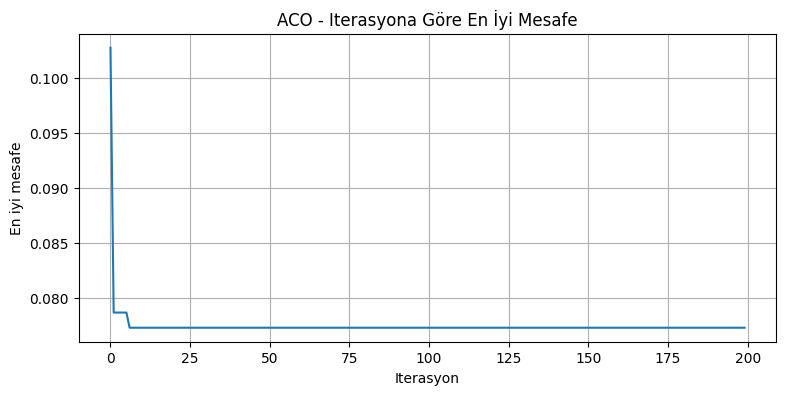

In [32]:
# ==========================================
# Grafik: iterasyona göre en iyi mesafe
# ==========================================

plt.figure(figsize=(9,4))
plt.plot(en_iyi_tarihce)
plt.xlabel("Iterasyon")
plt.ylabel("En iyi mesafe")
plt.title("ACO - Iterasyona Göre En İyi Mesafe")
plt.grid(True)
plt.show()


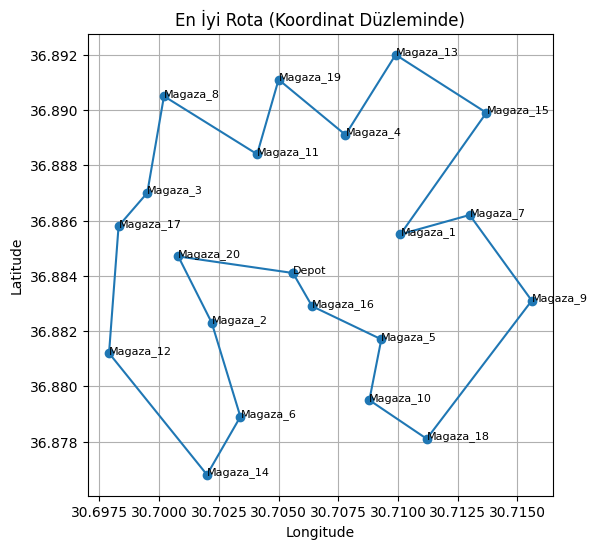

In [33]:
# ==========================================
# Rota çizimi (koordinat düzleminde)
# ==========================================

coords = np.array([lokasyonlar[name] for name in sehirler], dtype=float)

tur_coords = coords[en_iyi_tur]

plt.figure(figsize=(6,6))
plt.plot(tur_coords[:,1], tur_coords[:,0], marker="o")  # lon x ekseni, lat y ekseni

for idx, name in enumerate(sehirler):
    x = coords[idx,1]
    y = coords[idx,0]
    plt.text(x, y, name, fontsize=8)

plt.title("En İyi Rota (Koordinat Düzleminde)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
